In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hnc_n_component import  HNC_solver

# Two Species

Here we do QSP interactions between electrons and one ion type. 

Using $\tilde{r}\equiv r/r_s$, we implement potentials 
\begin{align}
\beta v_{ee}(\tilde{r}) &=  \frac{\Gamma_{ee}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right) +  \ln2 \exp\left[-\tilde{r}^2 r_s^2/(\pi \Lambda_e^2 \ln 2)\right]\\
\beta v_{ei}(\tilde{r}) &=  \frac{\Gamma_{ei}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right)\\
\beta v_{ii}(\tilde{r}) &=  \frac{\Gamma_{ii}}{\tilde{r}}
\end{align}
For  
\begin{align}
\Gamma_{ee}&=\frac{\beta e^2}{r_s}\\
\Gamma_{ei}&=\frac{\beta Z_i e^2}{r_s}\\
\Gamma_{ii}&=\frac{\beta Z_i^2 e^2}{r_s}\\
\end{align}

Define physical constants

In [2]:
# k_B = 1.380649e-23  # Boltzmann constant [J/K]
# hbar=  6.62607015e-34 # Planck [J/s]
eV = 0.0367512 # So 4 eV = 4 * 0.036.. in natural units
Kelvin = 8.61732814974493e-5*eV #Similarly, 1 Kelvin = 3.167e-6... in natural units 
π = np.pi
# [AU]
rs  = 3
T   = 0.0009500914508907175#1*eV 
Zstar=3

β   = 1/T
m_e = 1


Λe  = np.sqrt(  β*2*π /m_e )
Γee = β/rs 
Γei = Zstar*β/rs 
Γii = Zstar**2*β/rs 


Plug into get potentials

In [9]:
def βvee(r):
    return Γee/r*(1- np.exp(-r*rs/Λe))+ np.log(2) * np.exp(-r**2 * rs**2/( π*Λe**2*np.log(2)))

def βvee(r):
    return np.exp(-r/(5))*Γee/r*(1- np.exp(-r*rs/Λe))+ np.log(2) * np.exp(-r**2 * rs**2/( π*Λe**2*np.log(2)))


def βvei(r):
    return -Γei/r*(1- np.exp(-r*rs/Λe))

def βvei_atomic(r):
    r_c = 3/5 #3/5 r_s in linear n_b(r) model
    return (Γei/r*np.heaviside(r - r_c,0.5)  )*  (1- np.exp(-r*rs/Λe))

def βvii(r):
    return Γii/r 

def βvii(r):
    return Γii/r * np.exp(-r/(5)) 
    

First, we initialize the hnc

In [25]:
N_species = 2
Gamma = np.array(  [[Γii,  Γei],
                    [Γei,  Γee]])

names = ["Ion-1", "Electron", ] 
kappa = 3
rho = np.array([  3/(4*np.pi), 3/(4*np.pi), 3/(4*np.pi)  ])
hnc2 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, alpha=1e-2, rho = rho, 
                  num_iterations=int(1e2), R_max=100, N_bins=1000, names=names)

then we create the potential matrix, βu_matrix 

In [26]:
hnc2.βu_matrix[0,0] = βvii(hnc2.r_array)
hnc2.βu_matrix[1,0] = βvei_atomic(hnc2.r_array)
hnc2.βu_matrix[0,1] = βvei_atomic(hnc2.r_array)
hnc2.βu_matrix[1,1] = βvee(hnc2.r_array)

Err in c_r: 1338822.877
Err in c_r: 1325429.994
Err in c_r: 1312171.566
Err in c_r: 1298960.644
Err in c_r: 1297297.604
Err in c_r: 120064492091.149
Err in c_r: 1200655566.788
Err in c_r: 1188649011.120
Err in c_r: 1176762521.009
Err in c_r: 1164994895.799
Err in c_r: 1153344946.841
Err in c_r: 1141811497.372
Err in c_r: 1130393382.398
Err in c_r: 1119089448.574
Err in c_r: 1107898554.089
Err in c_r: 1096819568.548
Err in c_r: 1085851372.862
Err in c_r: 1074992859.134
Err in c_r: 1064242930.542
Err in c_r: 1053600501.237
Err in c_r: 1043064496.225
Err in c_r: 1032633851.262
Err in c_r: 1022307512.750
Err in c_r: 1012084437.622
Err in c_r: 1001963593.246
Err in c_r: 991943957.313
Err in c_r: 982024517.740
Err in c_r: 972204272.563
Err in c_r: 962482229.837
Err in c_r: 952857407.539
Err in c_r: 943328833.464
Err in c_r: 933895545.129
Err in c_r: 924556589.678
Err in c_r: 915311023.781
Err in c_r: 906157913.543
Err in c_r: 897096334.408
Err in c_r: 888125371.064
Err in c_r: 879244117.353


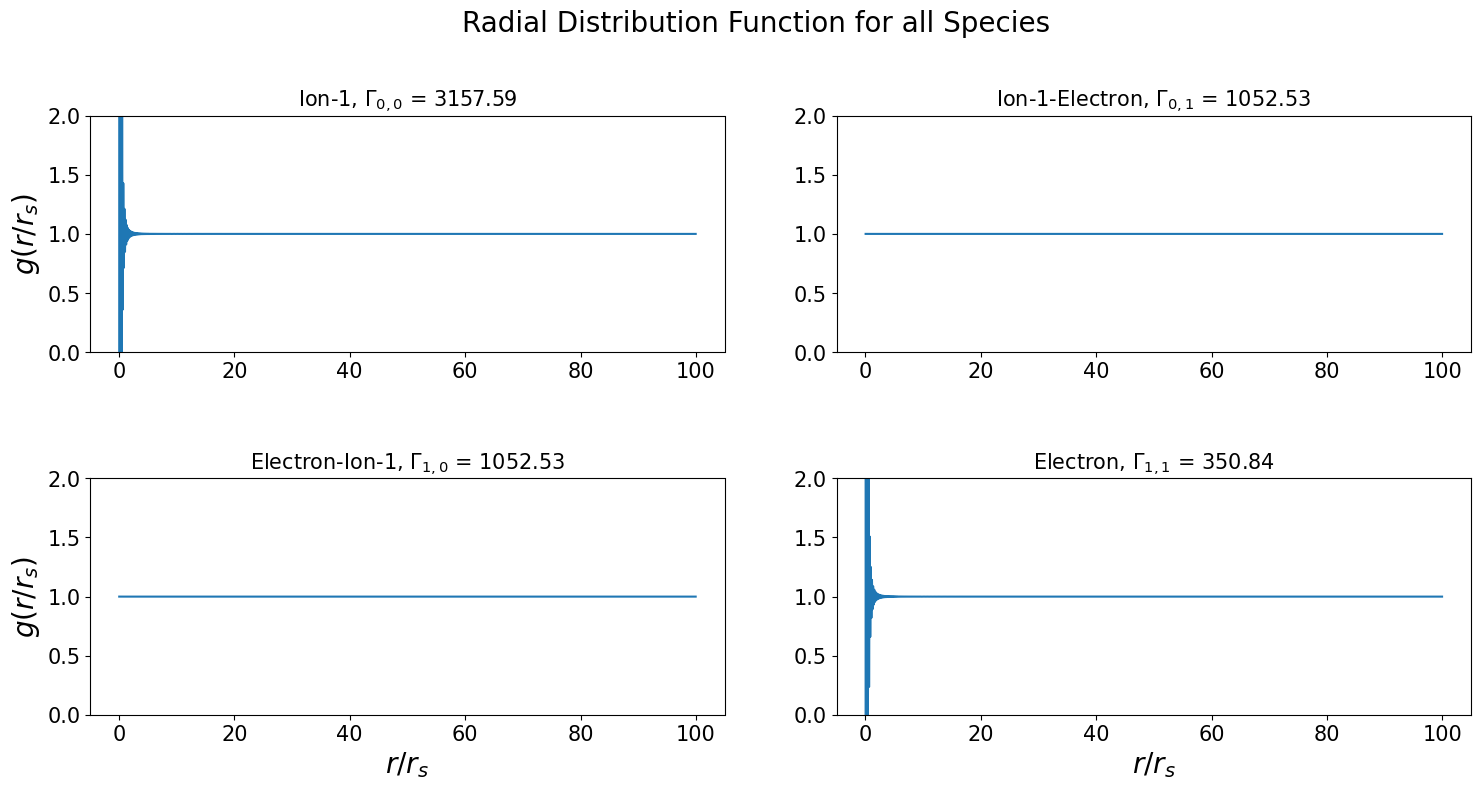

In [27]:
hnc2.HNC_solve()
# print(hnc.c_r_matrix)

h_r_matrix = hnc2.h_r_matrix
c_r_matrix = hnc2.c_r_matrix

# To get the radial distribution function g(r), you can add 1 to the h_r_matrix:
g_r_matrix = h_r_matrix + 1

# To visualize the results, you can use matplotlib to plot the g(r) function:
# hnc.plot_species((0,0))
# hnc.plot_species_convergence((0,0))
hnc2.plot_g_all_species()

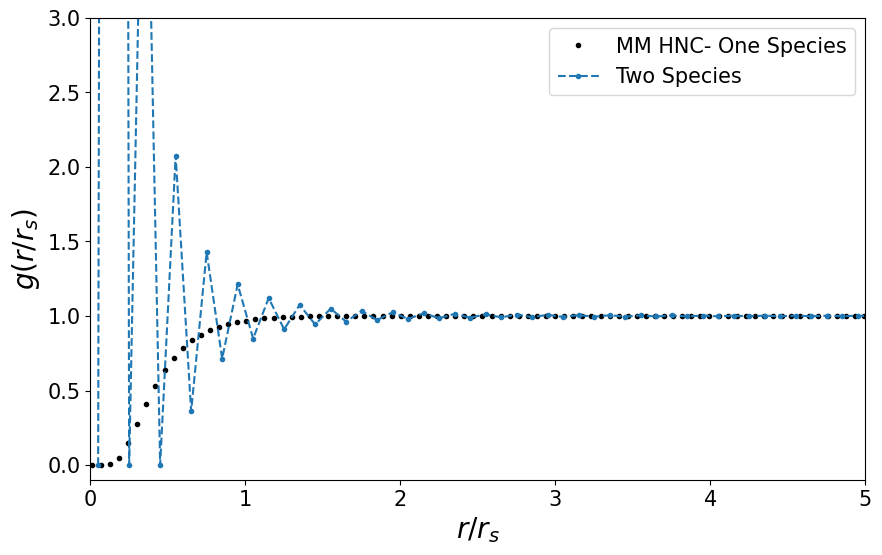

In [29]:
fig, ax = plt.subplots(figsize=(10,6))

MM_r, MM_g = np.loadtxt("/home/zach/plasma/atomic_forces/average_atom/jupyter/Murillo_HNC.txt").T
ax.plot(MM_r[::3], MM_g[::3], 'k.', label="MM HNC- One Species")
# ax.plot(hnc.r_array, hnc.h_r_matrix[0,0]+1, label="One Species")
ax.plot(hnc2.r_array, hnc2.h_r_matrix[0,0]+1,'--.', label="Two Species")
ax.set_ylabel(r'$g(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(-0.1,3)
ax.set_xlim(0,5)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

# Three Species

Err in c_r: 0.334
Err in c_r: 0.333
Err in c_r: 0.332
Err in c_r: 0.331
Err in c_r: 0.330
Err in c_r: 0.329
Err in c_r: 0.329
Err in c_r: 0.329
Err in c_r: 0.328
Err in c_r: 0.328
Err in c_r: 0.327
Err in c_r: 0.324
Err in c_r: 0.324
Err in c_r: 0.323
Err in c_r: 0.322
Err in c_r: 0.322
Err in c_r: 0.321
Err in c_r: 0.321
Err in c_r: 0.321
Err in c_r: 0.320
Err in c_r: 0.318
Err in c_r: 0.317
Err in c_r: 0.317
Err in c_r: 0.316
Err in c_r: 0.316
Err in c_r: 0.315
Err in c_r: 0.313
Err in c_r: 0.311
Err in c_r: 0.310
Err in c_r: 0.309
Err in c_r: 0.308
Err in c_r: 0.308
Err in c_r: 0.307
Err in c_r: 0.307
Err in c_r: 0.306
Err in c_r: 0.306
Err in c_r: 0.306
Err in c_r: 0.305
Err in c_r: 0.305
Err in c_r: 0.304
Err in c_r: 0.304
Err in c_r: 0.304
Err in c_r: 0.302
Err in c_r: 0.300
Err in c_r: 0.298
Err in c_r: 0.298
Err in c_r: 0.297
Err in c_r: 0.297
Err in c_r: 0.296
Err in c_r: 0.296
Err in c_r: 0.295
Err in c_r: 0.295
Err in c_r: 0.295
Err in c_r: 0.293
Err in c_r: 0.293
Err in c_r

Err in c_r: 0.143
Err in c_r: 0.143
Err in c_r: 0.143
Err in c_r: 0.143
Err in c_r: 0.143
Err in c_r: 0.142
Err in c_r: 0.142
Err in c_r: 0.142
Err in c_r: 0.142
Err in c_r: 0.142
Err in c_r: 0.142
Err in c_r: 0.142
Err in c_r: 0.141
Err in c_r: 0.141
Err in c_r: 0.141
Err in c_r: 0.141
Err in c_r: 0.141
Err in c_r: 0.141
Err in c_r: 0.140
Err in c_r: 0.140
Err in c_r: 0.140
Err in c_r: 0.140
Err in c_r: 0.140
Err in c_r: 0.140
Err in c_r: 0.140
Err in c_r: 0.139
Err in c_r: 0.139
Err in c_r: 0.139
Err in c_r: 0.139
Err in c_r: 0.139
Err in c_r: 0.139
Err in c_r: 0.138
Err in c_r: 0.138
Err in c_r: 0.138
Err in c_r: 0.138
Err in c_r: 0.137
Err in c_r: 0.137
Err in c_r: 0.137
Err in c_r: 0.137
Err in c_r: 0.137
Err in c_r: 0.137
Err in c_r: 0.136
Err in c_r: 0.136
Err in c_r: 0.136
Err in c_r: 0.136
Err in c_r: 0.136
Err in c_r: 0.136
Err in c_r: 0.135
Err in c_r: 0.135
Err in c_r: 0.135
Err in c_r: 0.135
Err in c_r: 0.135
Err in c_r: 0.135
Err in c_r: 0.135
Err in c_r: 0.134
Err in c_r

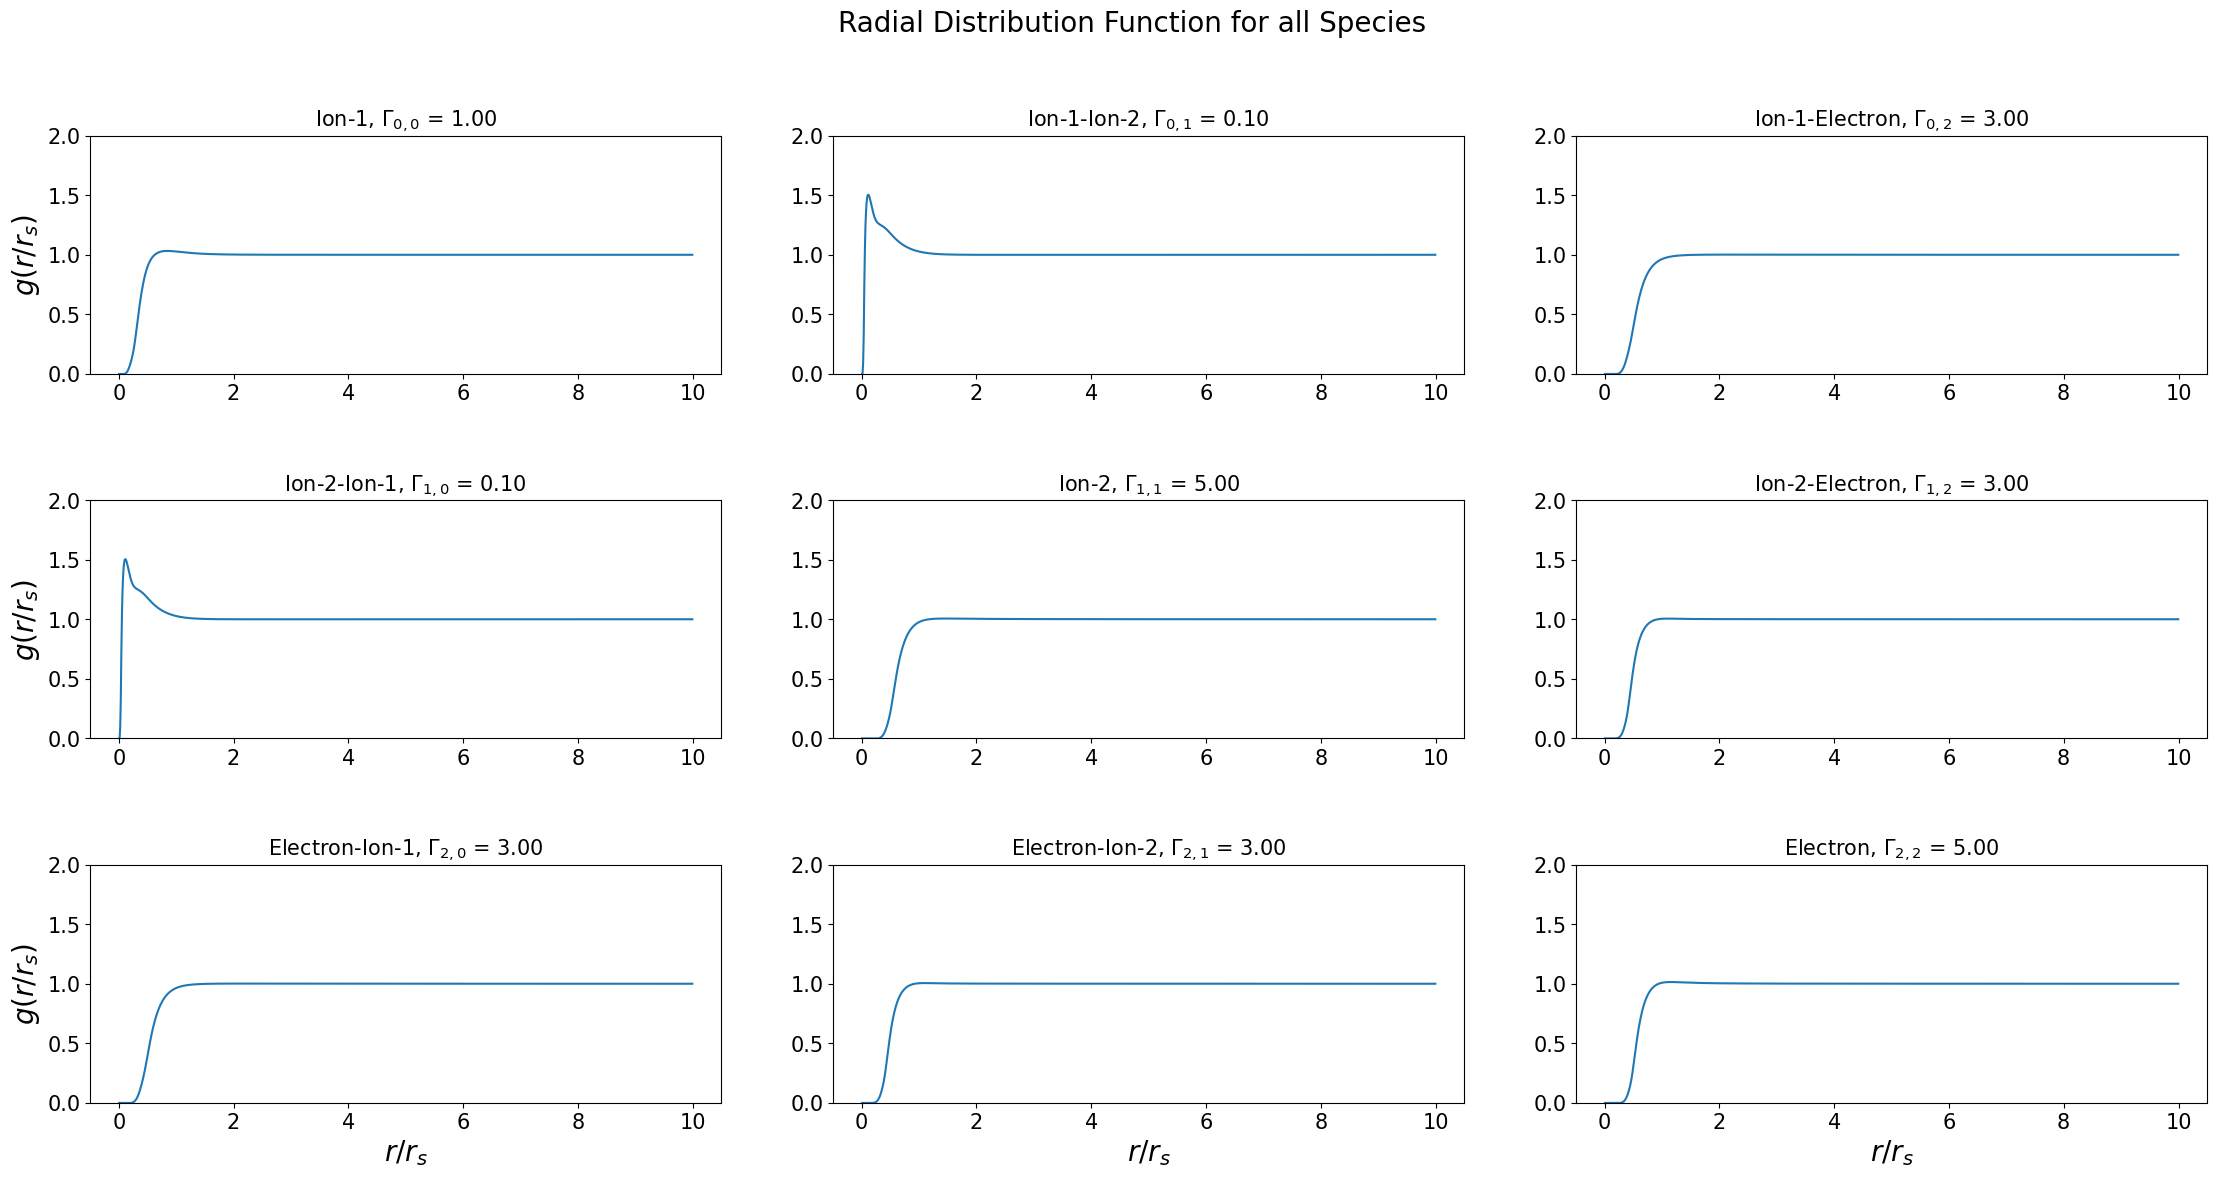

In [5]:
N_species = 3
Gamma = np.array(  [[1,  0.1,  3],
                    [0.1,  5,   3],
                    [3,    3,   5]])

names = ["Ion-1","Ion-2", "Electron", ] 
kappa = 3
rho = np.array([  3/(4*np.pi), 3/(4*np.pi), 3/(4*np.pi)  ])
hnc3 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-1, alpha=1e-3, rho = rho, num_iterations=int(1e4), R_max=10, N_bins=1000, names=names)

hnc3.HNC_solve()
# print(hnc.c_r_matrix)

h_r_matrix = hnc3.h_r_matrix
c_r_matrix = hnc3.c_r_matrix

# To get the radial distribution function g(r), you can add 1 to the h_r_matrix:
g_r_matrix = h_r_matrix + 1

# To visualize the results, you can use matplotlib to plot the g(r) function:
# hnc.plot_species((0,0))
# hnc.plot_species_convergence((0,0))
hnc3.plot_g_all_species()

In [6]:
hnc3.h_r_matrix[0,0]/hnc.h_r_matrix[0,0]

array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00015241e+00,  9.99987315e-01,  1.00092731e+00,  9.98306536e-01,
        9.97145132e-01,  9.95661636e-01,  9.93938415e-01,  9.92083315e-01,
        9.90206657e-01,  9.88410161e-01,  9.86778949e-01,  9.85371002e-01,
        9.84211301e-01,  9.83281580e-01,  9.82470745e-01,  9.81394177e-01,
        9.79186175e-01,  9.74793469e-01,  9.67244837e-01,  9.56023636e-01,
        9.40715287e-01,  9.21786982e-01,  8.99340382e-01,  8.74333135e-01,
        8.46859185e-01,  8.17924324e-01,  7.87427531e-01,  7.56290359e-01,
        7.24233456e-01,  6.92089336e-01,  6.59459656e-01,  6.27109274e-01,
        5.94570094e-01,  5.62558495e-01,  5.30568860e-01,  4.99281150e-01,
        4.68168097e-01,  4.37874966e-01,  4.07856027e-01,  3.78719905e-01,
        3.49902583e-01,  3.21976511e-01,  2.94363911e-01,  2.67612177e-01,
        2.41140789e-01,  

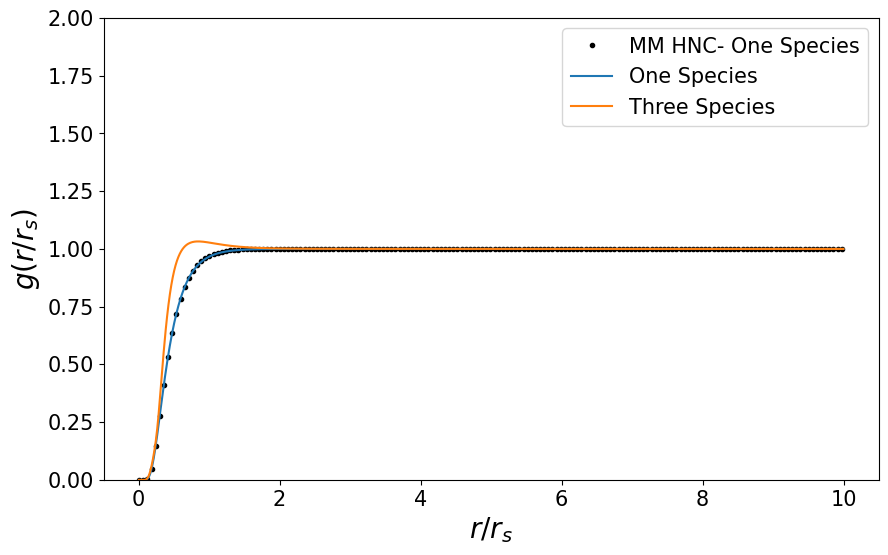

In [7]:
fig, ax = plt.subplots(figsize=(10,6))

MM_r, MM_g = np.loadtxt("/home/zach/plasma/atomic_forces/average_atom/jupyter/Murillo_HNC.txt").T
ax.plot(MM_r[::3], MM_g[::3], 'k.', label="MM HNC- One Species")
ax.plot(hnc.r_array, hnc.h_r_matrix[0,0]+1, label="One Species")
ax.plot(hnc3.r_array, hnc3.h_r_matrix[0,0]+1, label="Three Species")
ax.set_ylabel(r'$g(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(0,2)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

# Effective Potentials

In [8]:
hnc2.invert_HNC( 1 , alpha=1, tol=1e-3)

βu Err: 1.144e+04
βu Err: 1.035e+04
βu Err: 9.368e+03
βu Err: 8.477e+03
βu Err: 7.669e+03
βu Err: 6.939e+03
βu Err: 6.279e+03
βu Err: 5.681e+03
βu Err: 5.140e+03
βu Err: 4.651e+03
βu Err: 4.208e+03
βu Err: 3.807e+03
βu Err: 3.445e+03
βu Err: 3.117e+03
βu Err: 2.820e+03
βu Err: 2.552e+03
βu Err: 2.309e+03
βu Err: 2.089e+03
βu Err: 1.890e+03
βu Err: 1.710e+03
βu Err: 1.547e+03
βu Err: 1.400e+03
βu Err: 1.267e+03
βu Err: 1.146e+03
βu Err: 1.037e+03
βu Err: 9.382e+02
βu Err: 8.489e+02
βu Err: 7.680e+02
βu Err: 6.949e+02
βu Err: 6.288e+02
βu Err: 5.689e+02
βu Err: 5.147e+02
βu Err: 4.657e+02
βu Err: 4.214e+02
βu Err: 3.813e+02
βu Err: 3.450e+02
βu Err: 3.121e+02
βu Err: 2.824e+02
βu Err: 2.555e+02
βu Err: 2.312e+02
βu Err: 2.092e+02
βu Err: 1.893e+02
βu Err: 1.712e+02
βu Err: 1.549e+02
βu Err: 1.402e+02
βu Err: 1.268e+02
βu Err: 1.148e+02
βu Err: 1.038e+02
βu Err: 9.395e+01
βu Err: 8.501e+01
βu Err: 7.692e+01
βu Err: 6.959e+01
βu Err: 6.297e+01
βu Err: 5.697e+01
βu Err: 5.155e+01
βu Err: 4.

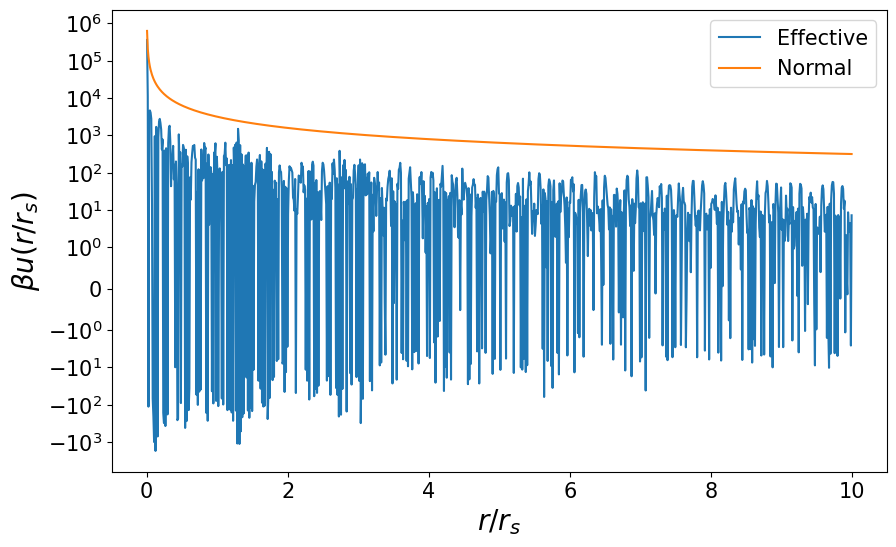

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(hnc2.r_array, hnc2.βueff[0,0], label="Effective")
ax.plot(hnc2.r_array, hnc2.βu_matrix[0,0], label="Normal")
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(,2)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

# Check!

In [ ]:
N_species = 1
Gamma = np.array(  [[1]])
names = ["Ion Effective"] 
kappa = 3
rho = np.array([3/(4*np.pi)])
hnc_check = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, alpha=1e-3, rho = rho, num_iterations=int(1e4), R_max=10, N_bins=1000, names=names)
hnc_check.βu_matrix = hnc2.βueff.copy()
hnc_check.HNC_solve()


In [ ]:
hnc_check.plot_g_all_species()

In [ ]:
hnc_check.h_r_matrix[0,0]/hnc.h_r_matrix[0,0]